In [5]:
import us
import pandas as pd
import geopandas
import numpy as np

from shapely.geometry import Point
from geopandas.plotting import plot_point_collection
from litecoder.models import WOFLocality
from boltons.iterutils import pairwise

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
mpl.style.use('seaborn-muted')

In [7]:
densities = pd.read_json('../data/densities.json/part-00000-72013f5c-4328-4f7c-abd9-93fa6e24f249-c000.json', lines=True)

In [8]:
densities.head(10)

density   latitude   longitude     wof_id
0  0.059421  41.119955  -77.428652  101719875
1  0.048786  37.780064  -81.818145  101732091
2  0.032297  38.301310 -120.277140   85927571
3  0.063524  39.757649  -89.902664   85940457
4  0.073802  40.810509  -78.234311  101720101
5  0.066747  38.210881  -81.421770  101731783
6  0.008645  40.452370 -123.509760   85927739
7  0.028829  39.026113  -88.568299   85940393
8  0.417278  40.658455  -75.495211  101719963
9  0.068210  39.340914  -80.016198  101731717

In [9]:
counts = pd.read_json('../data/wof-id-counts.json/part-00000-bc35b414-cc6a-4865-8073-0495b0c8542a-c000.json', lines=True)

In [10]:
counts.head(10)

count     wof_id
0    41599   85923761
1     1805  101732885
2  1325468   85932547
3   405708   85914453
4     7181  101721637
5   186873   85975813
6    45878   85948293
7    13790   85968515
8   188395  101724555
9    80296   85950415

In [11]:
df = densities.merge(counts)

In [12]:
df.head(10)

density   latitude   longitude     wof_id  count
0  0.059421  41.119955  -77.428652  101719875     44
1  0.032297  38.301310 -120.277140   85927571      3
2  0.073802  40.810509  -78.234311  101720101     20
3  0.066747  38.210881  -81.421770  101731783    452
4  0.008645  40.452370 -123.509760   85927739      6
5  0.028829  39.026113  -88.568299   85940393    990
6  0.417278  40.658455  -75.495211  101719963   1947
7  0.068210  39.340914  -80.016198  101731717   3082
8  0.940675  34.469990 -118.196740   85928279   1462
9  0.059638  39.434497  -89.995913   85939877    336

In [13]:
rows = []
for loc in WOFLocality.clean_us_cities():
    rows.append((loc.wof_id, loc.name, loc.us_state_abbr, loc.population))
    
cities = pd.DataFrame(rows, columns=('wof_id', 'name', 'state', 'population'))

In [14]:
cities.head(10)

wof_id         name state  population
0  85897411  Valley Head    AL       558.0
1  85897417     Sylvania    AL      1837.0
2  85897421       Shiloh    AL       274.0
3  85897425   Rainsville    AL      4948.0
4  85897429       Powell    AL         NaN
5  85897435   Pine Ridge    AL       282.0
6  85897439      Mentone    AL       360.0
7  85897443     Lakeview    AL       143.0
8  85897447    Tuscumbia    AL      8423.0
9  85897453    Geraldine    AL       896.0

In [15]:
df = df.merge(cities)

In [16]:
df['point'] = df.apply(lambda r: Point(r.longitude, r.latitude), axis=1)

In [78]:
gdf = geopandas.GeoDataFrame(df, geometry='point', crs={'init': 'epsg:4326', 'no_defs': True})

In [79]:
states = geopandas.read_file('../data/cb_2017_us_state_5m/cb_2017_us_state_5m.shp')

In [112]:
states = states.to_crs(epsg=3395)
gdf = gdf.to_crs(epsg=3395)

In [93]:
def plot_state(state):
    
    ax = states[states.STUSPS==state].plot(color='white', edgecolor='black', figsize=(20,20))
    sdf = gdf[gdf.state==state]
    
    sdf.plot(column='density', ax=ax, markersize=sdf['count'] / 200, cmap='Reds')
    
    for r in sdf[sdf['count'] > 100000].itertuples():
        plt.annotate(
            '%.2f' % r.density,
            (r.point.x, r.point.y),
            fontsize=18,
            horizontalalignment='center',
            verticalalignment='center',
        )

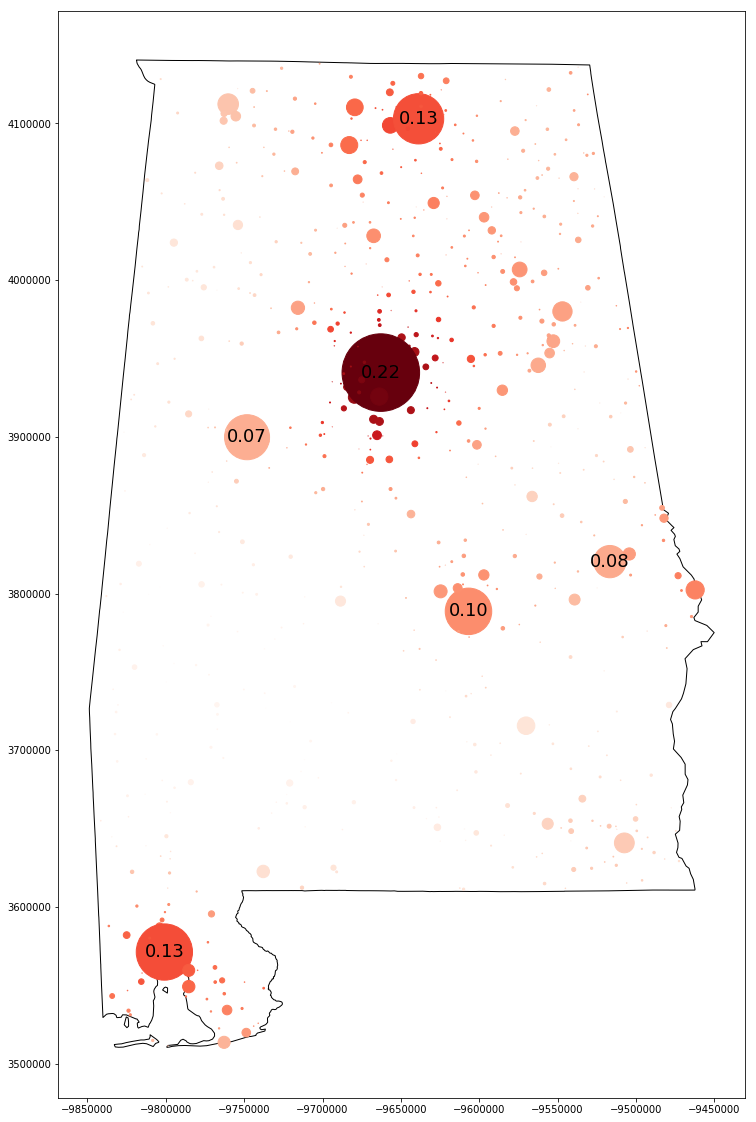

In [94]:
plot_state('AL')

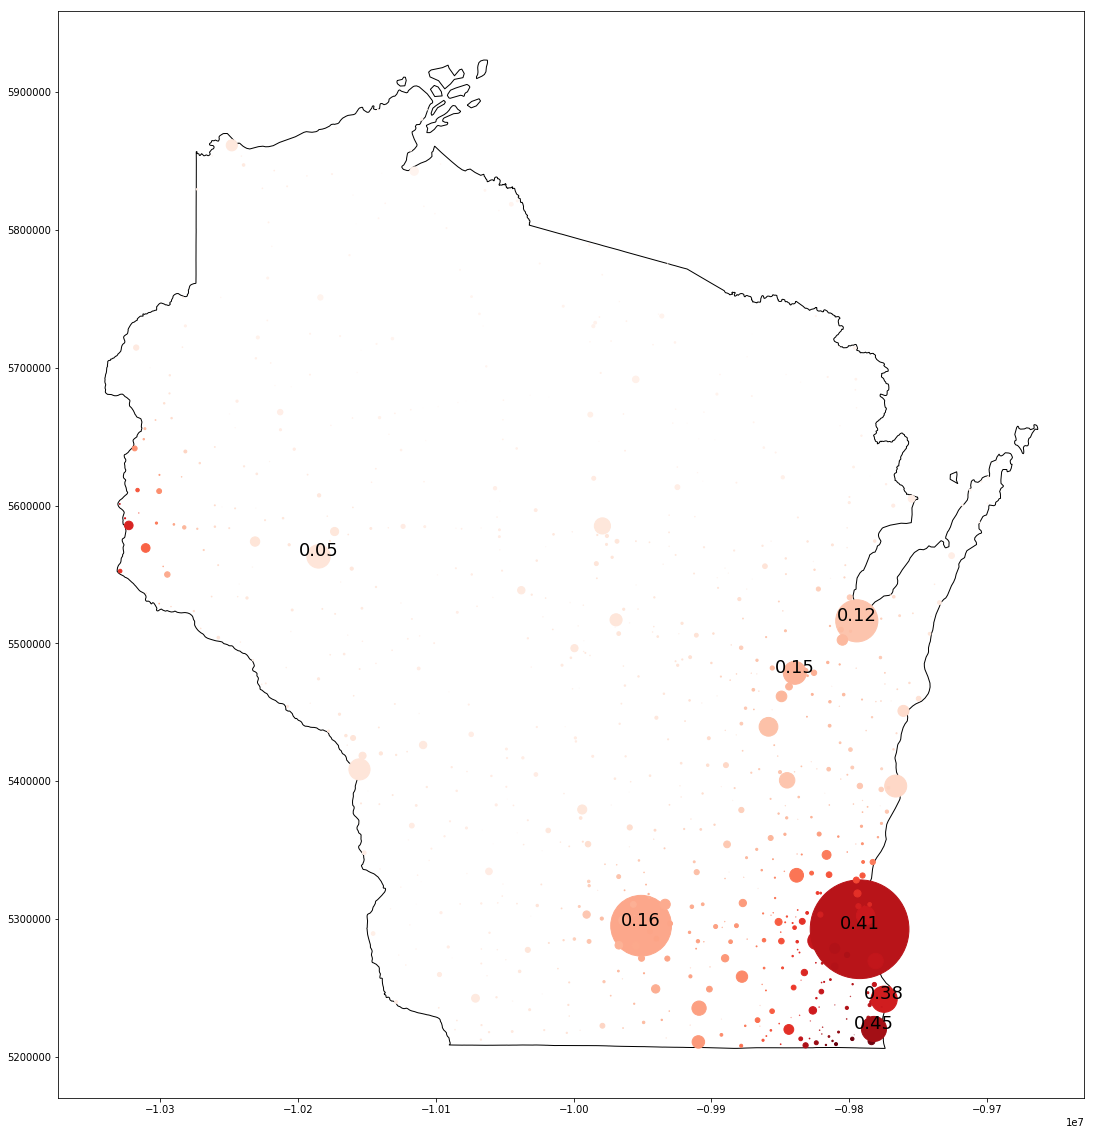

In [89]:
plot_state('WI')

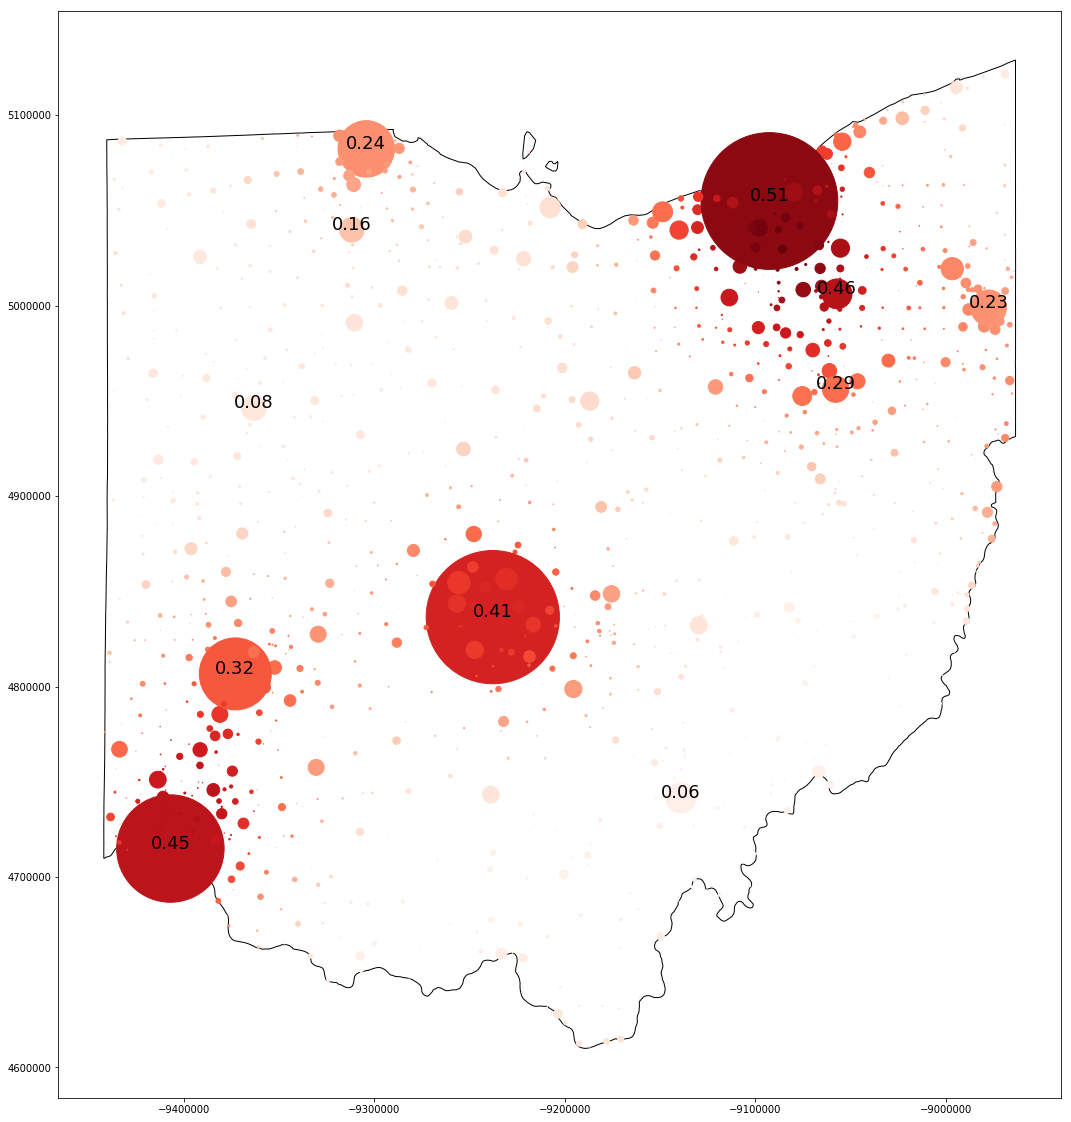

In [90]:
plot_state('OH')

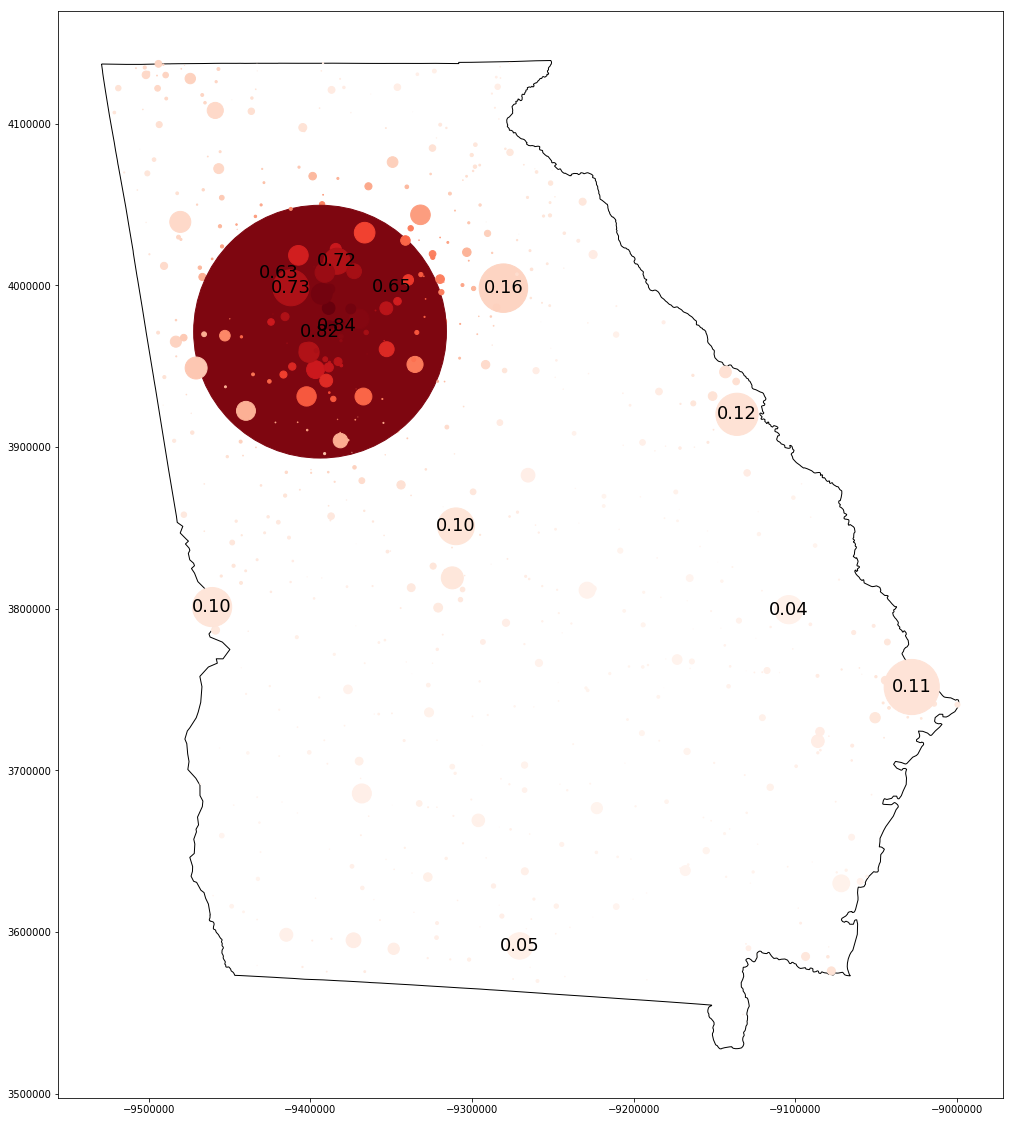

In [95]:
plot_state('GA')

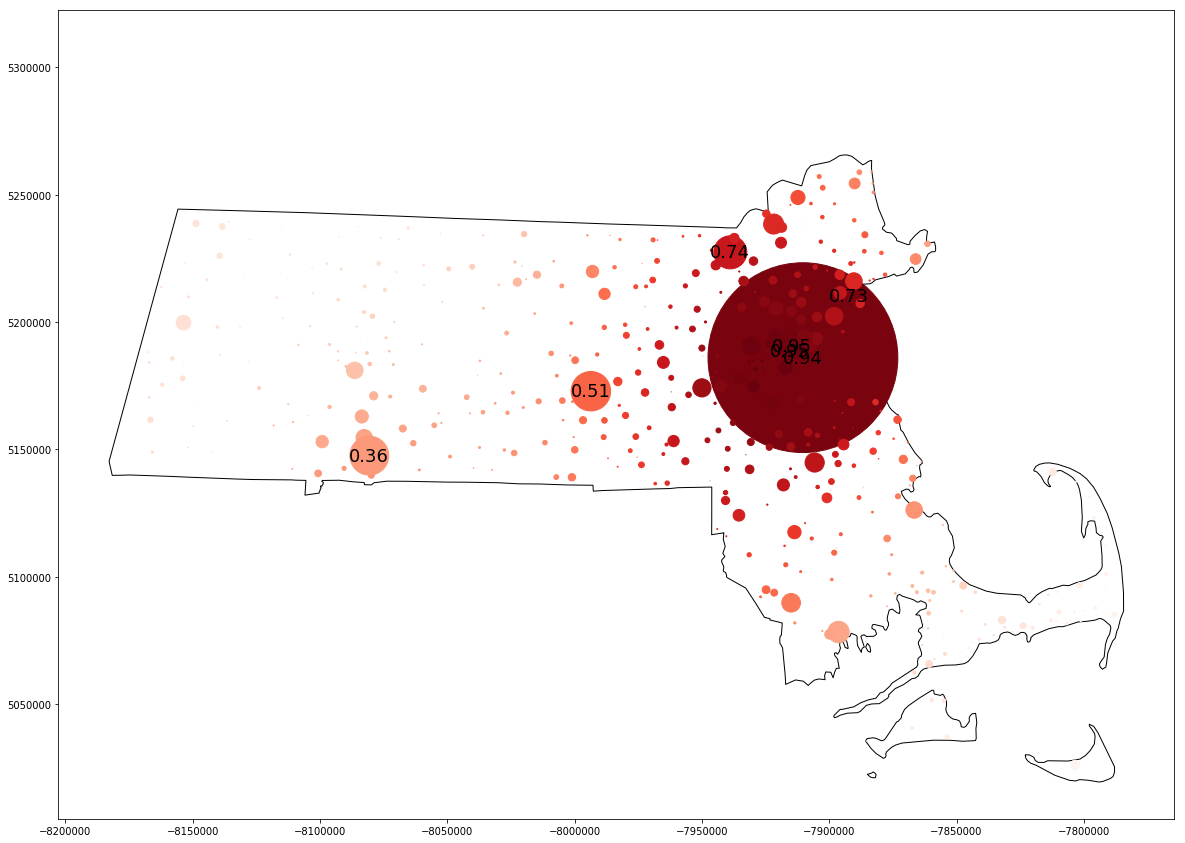

In [96]:
plot_state('MA')

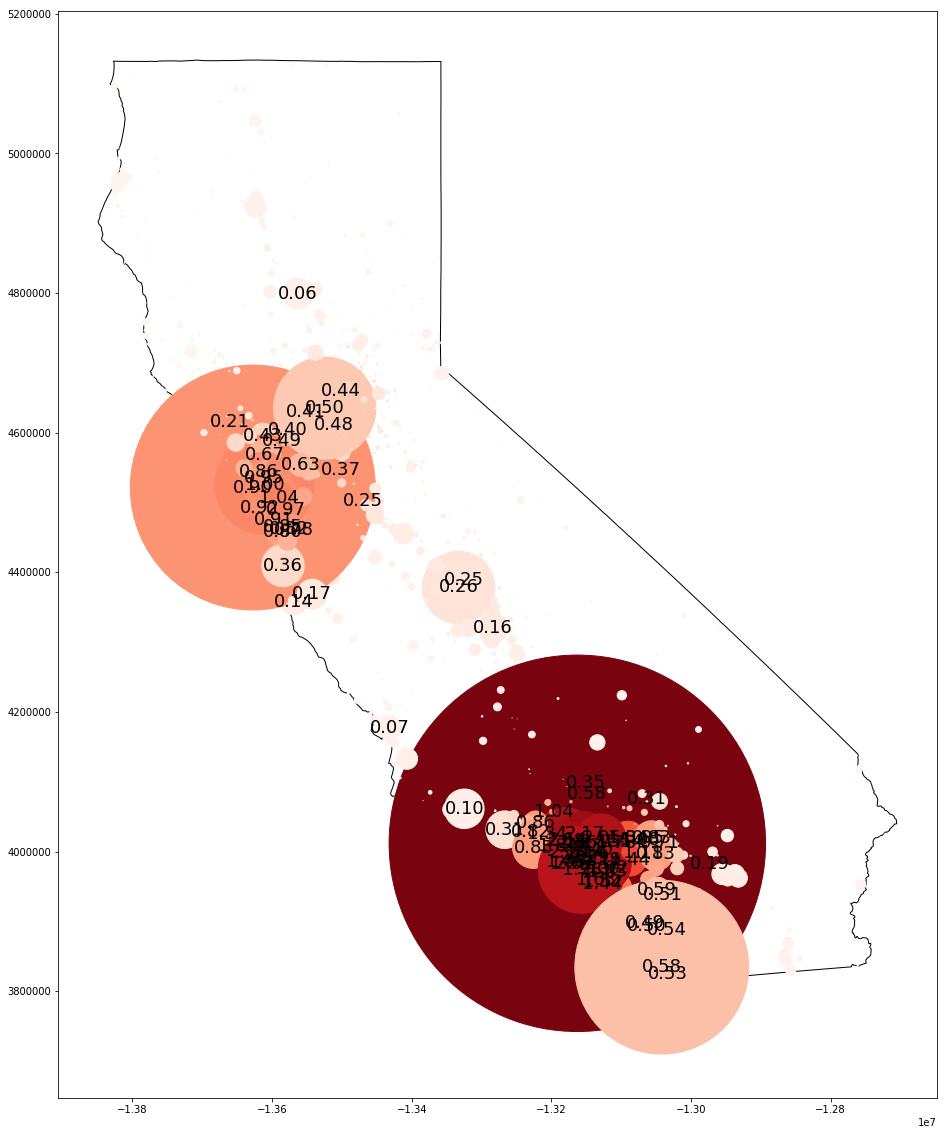

In [97]:
plot_state('CA')

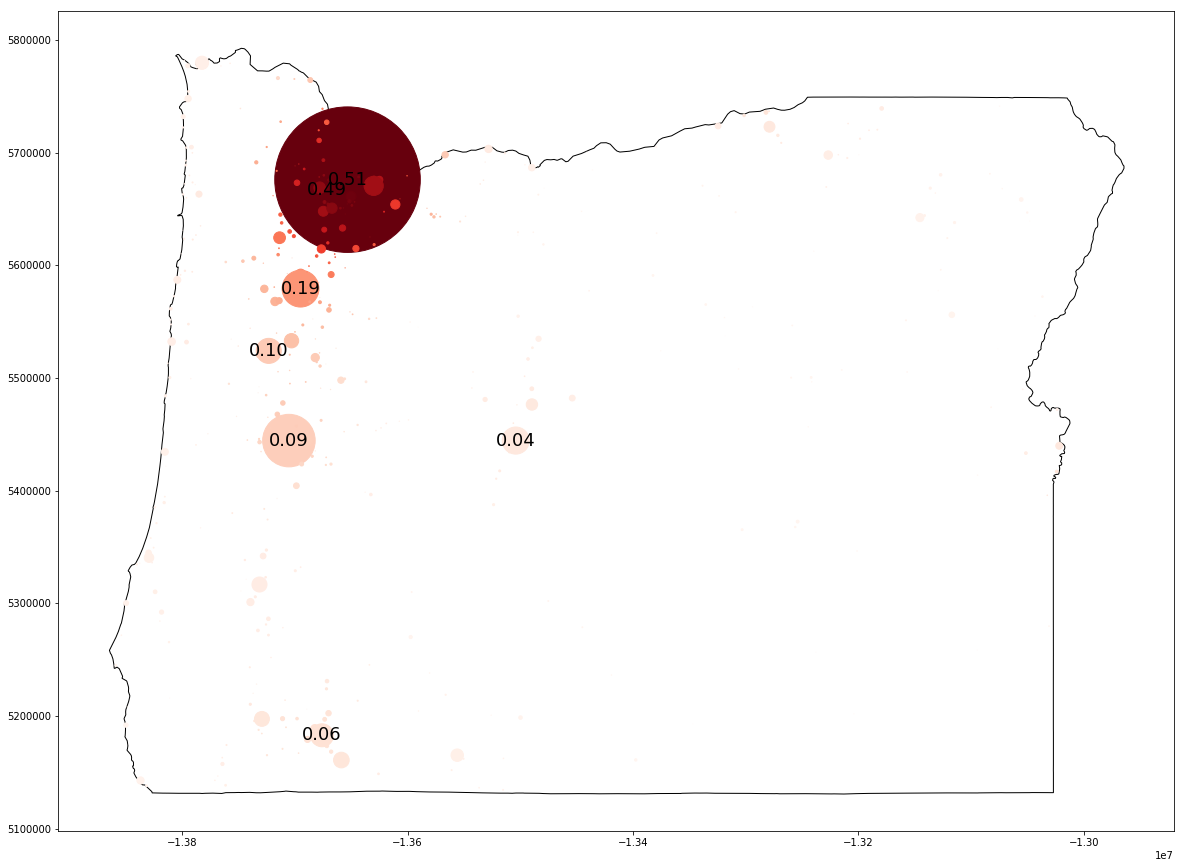

In [98]:
plot_state('OR')

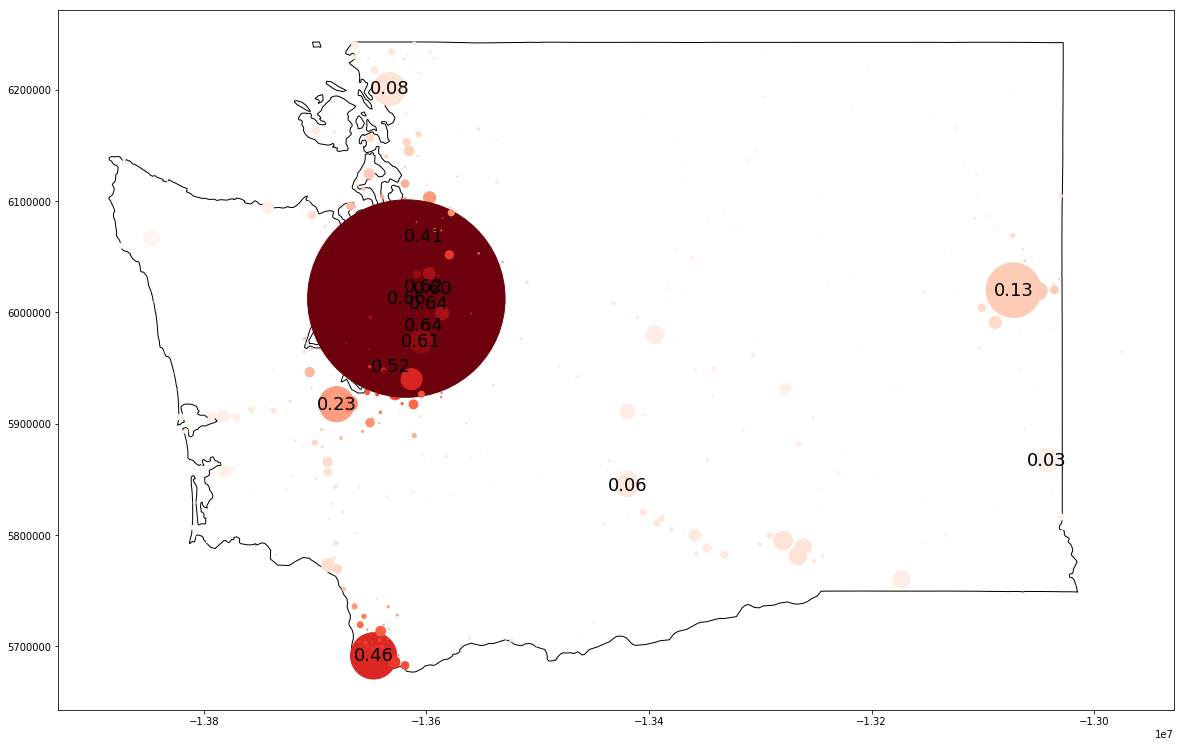

In [99]:
plot_state('WA')

In [100]:
df[(df.name=='Lunenburg')&(df.state=='MA')]

density  latitude  longitude    wof_id  count       name state  \
74  0.476174  42.59453  -71.72452  85950731   2352  Lunenburg    MA   

    population                       point  
74      1760.0  POINT (-71.72452 42.59453)

In [101]:
df[(df.name=='Tuscaloosa')&(df.state=='AL')]

density  latitude  longitude    wof_id   count        name state  \
20599  0.07433  33.20984  -87.56917  85914453  405708  Tuscaloosa    AL   

       population                       point  
20599     90468.0  POINT (-87.56917 33.20984)

In [102]:
df[(df.name=='Los Angeles')&(df.state=='CA')]

density  latitude  longitude    wof_id     count         name state  \
19518  2.359399  34.05223 -118.24368  85923517  28344936  Los Angeles    CA   

       population                        point  
19518   3792621.0  POINT (-118.24368 34.05223)

In [103]:
states_cont = [s.abbr for s in us.states.STATES_CONTIGUOUS]

In [104]:
def plot_usa(df):
    ax = states[states.STUSPS.isin(states_cont)].plot(color='white', edgecolor='black', figsize=(50,20))
    df = df[df.state.isin(states_cont)]
    plot_point_collection(ax, df.point, df.density, markersize=5, cmap='Reds')

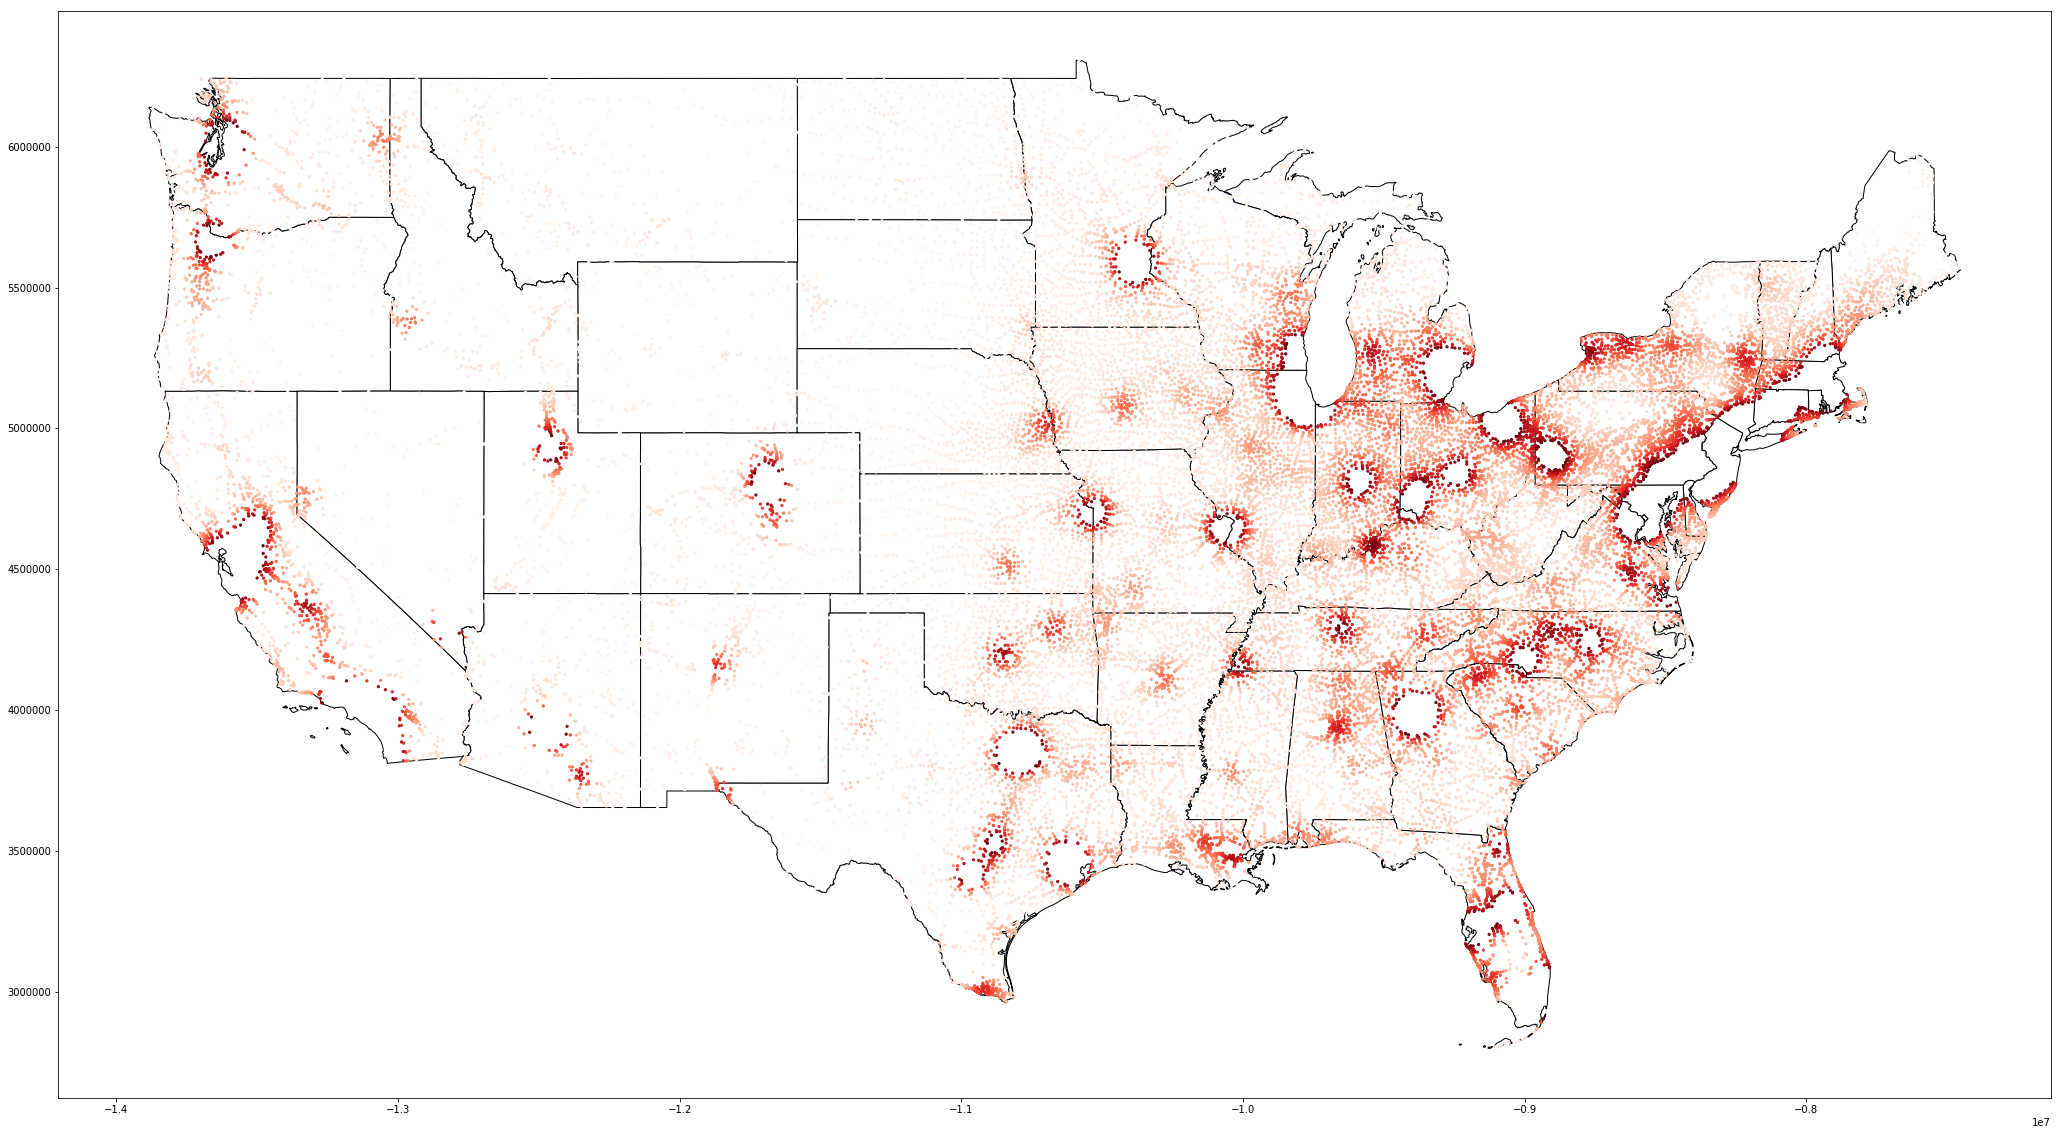

In [105]:
plot_usa(gdf[gdf.density<0.3])

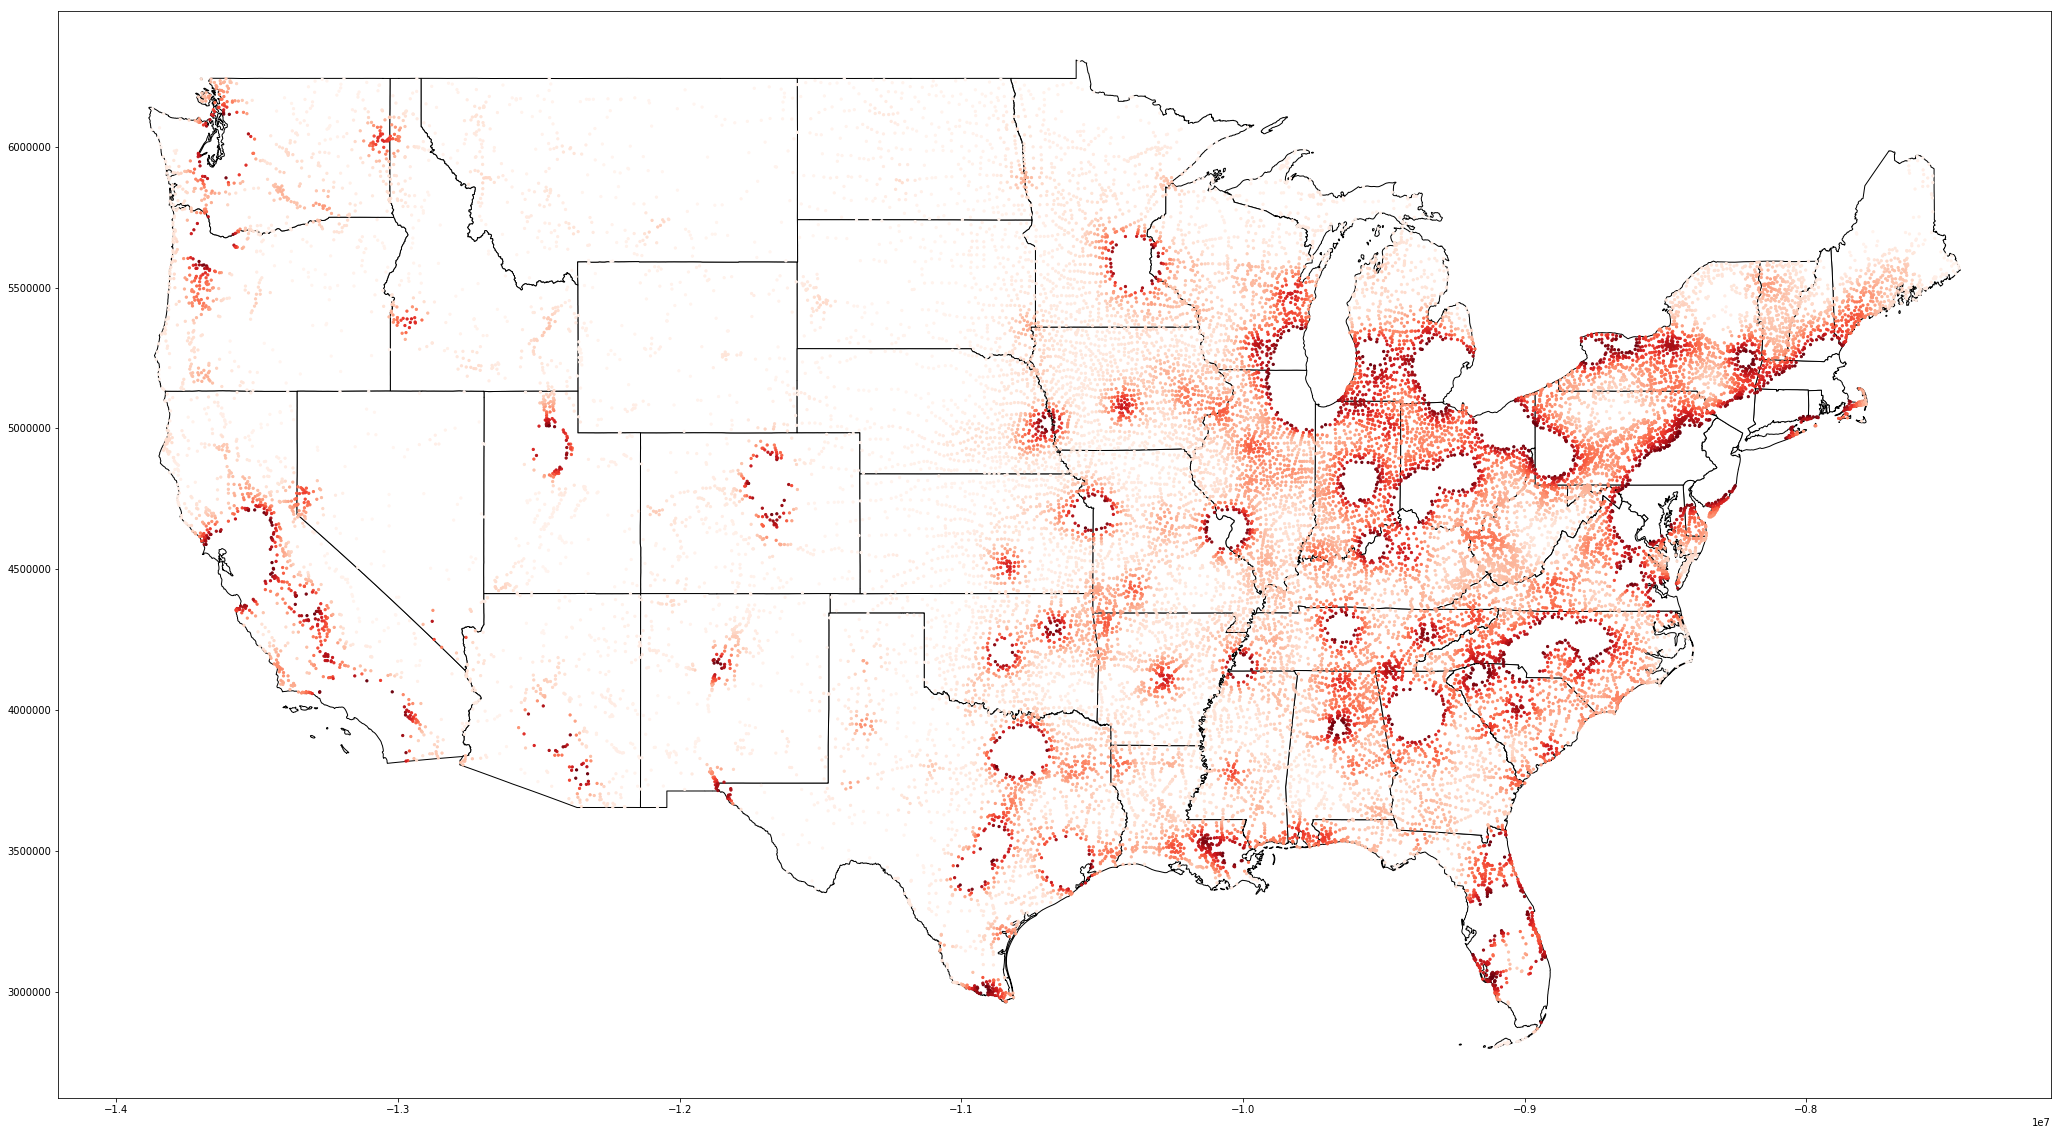

In [106]:
plot_usa(gdf[gdf.density<0.2])

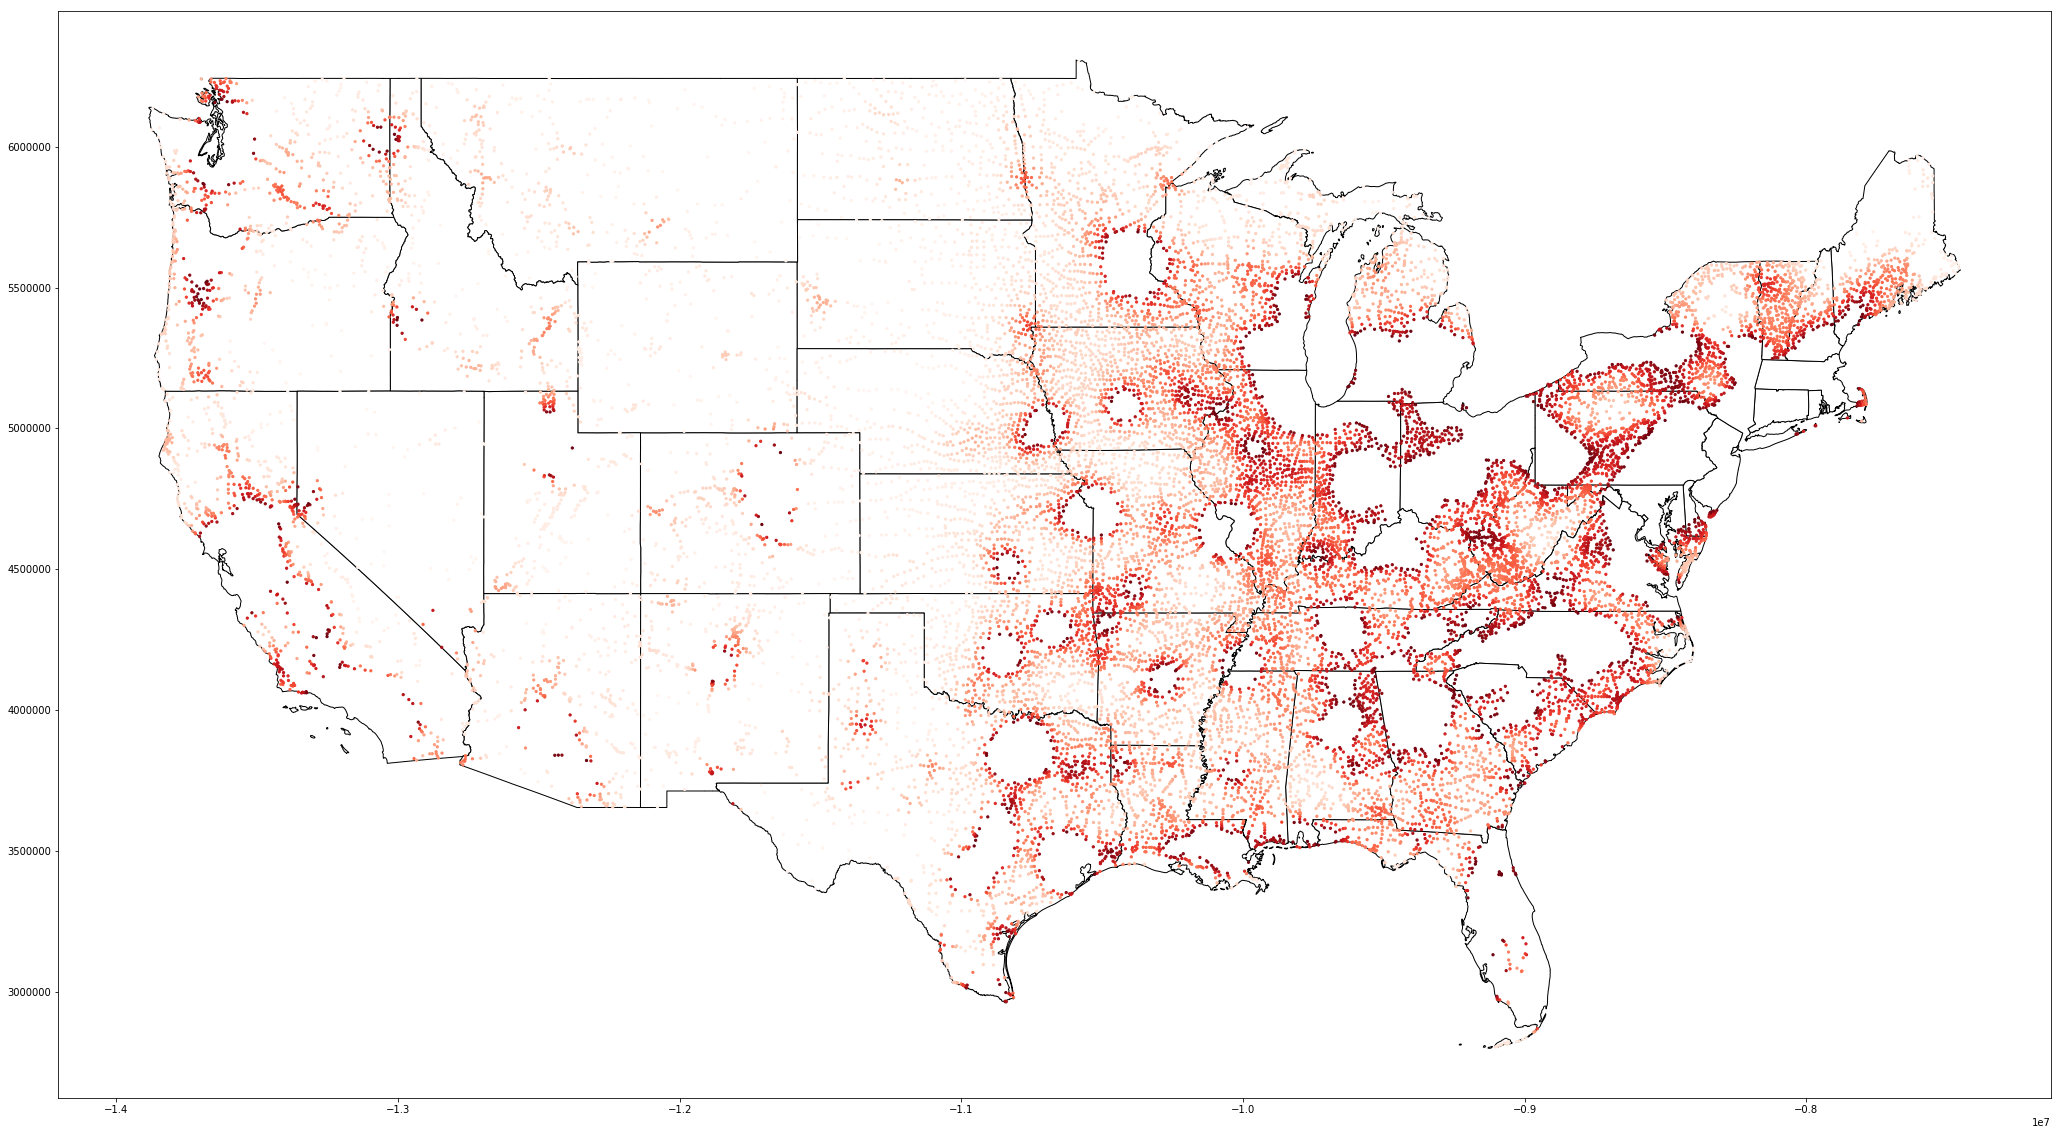

In [107]:
plot_usa(gdf[gdf.density<0.1])

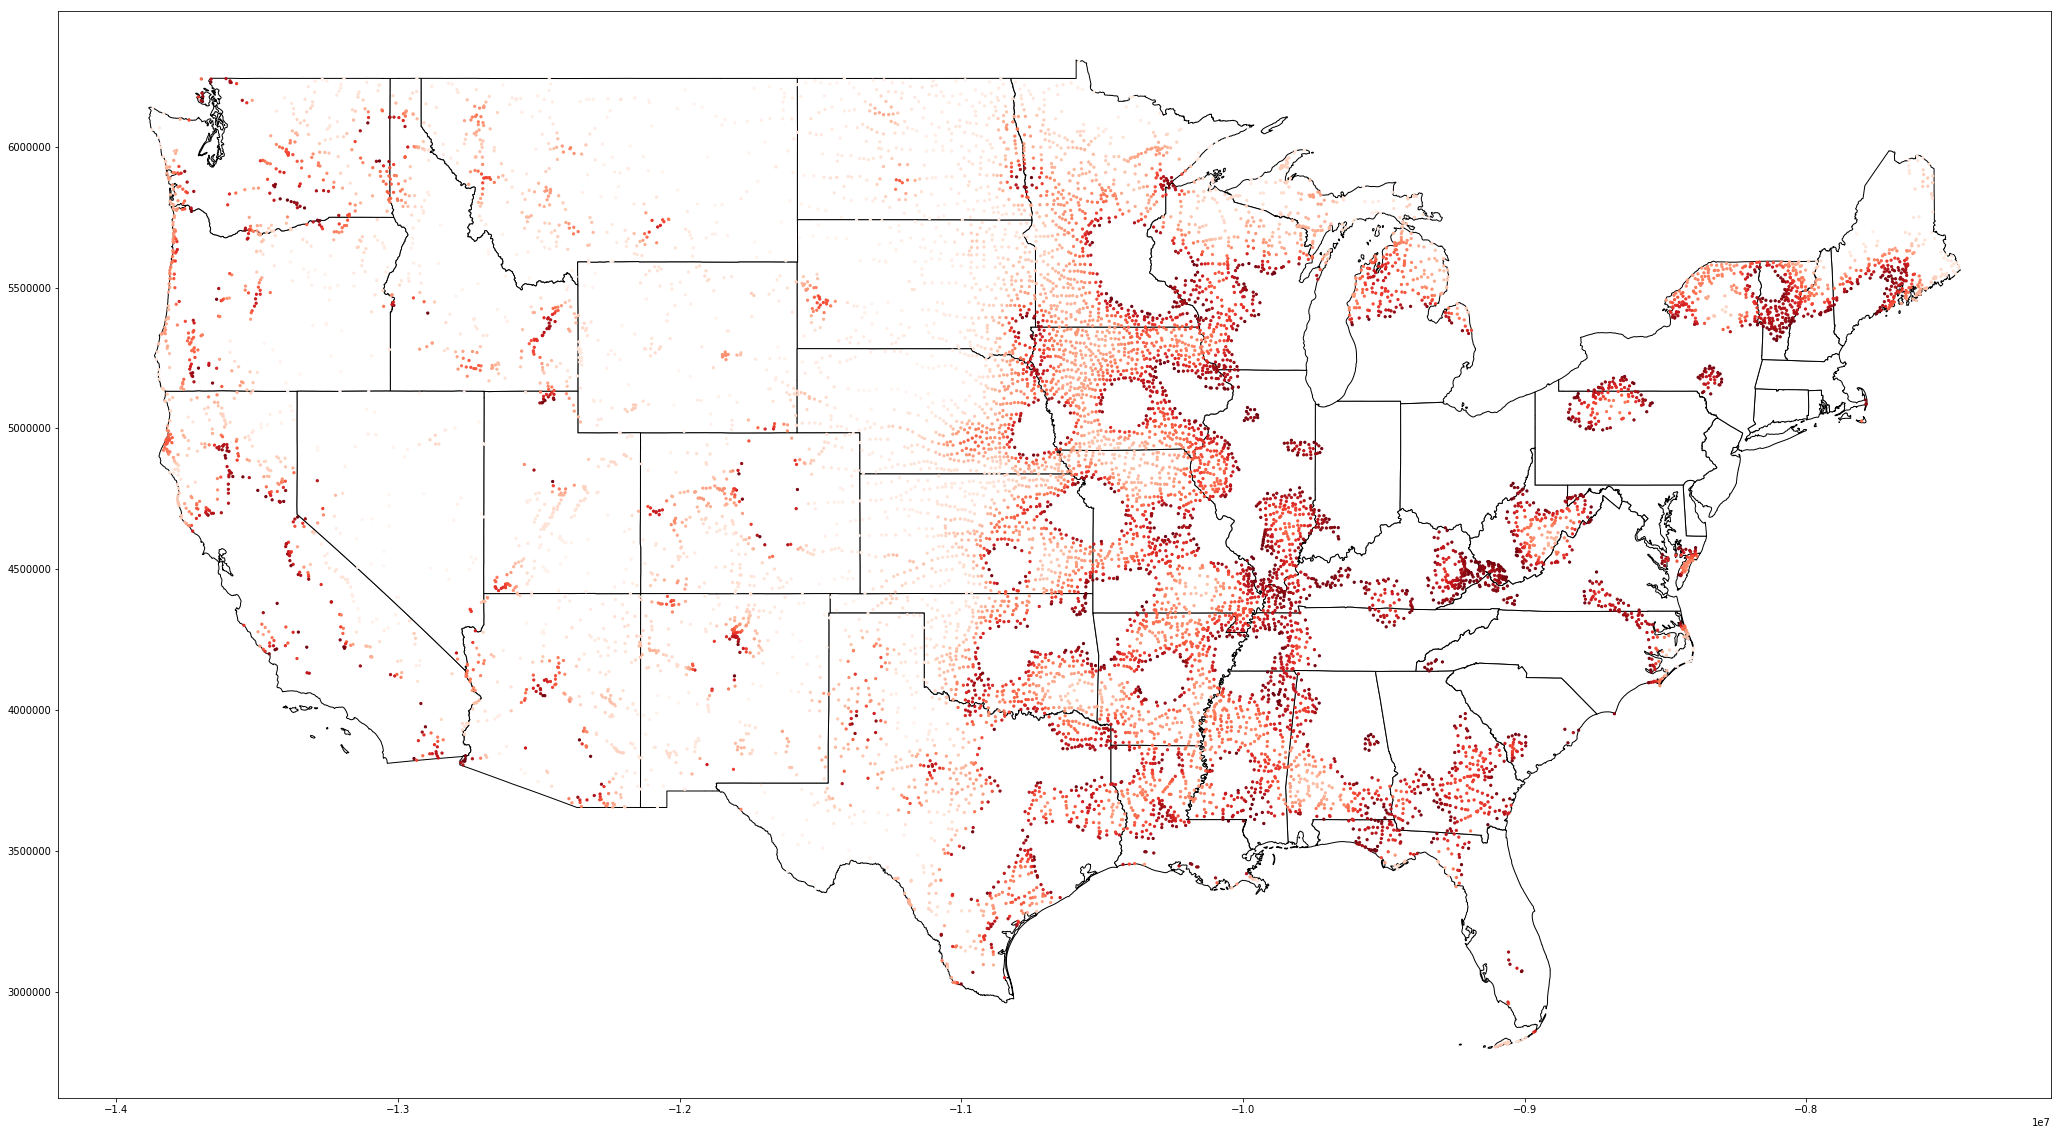

In [108]:
plot_usa(gdf[gdf.density<0.05])

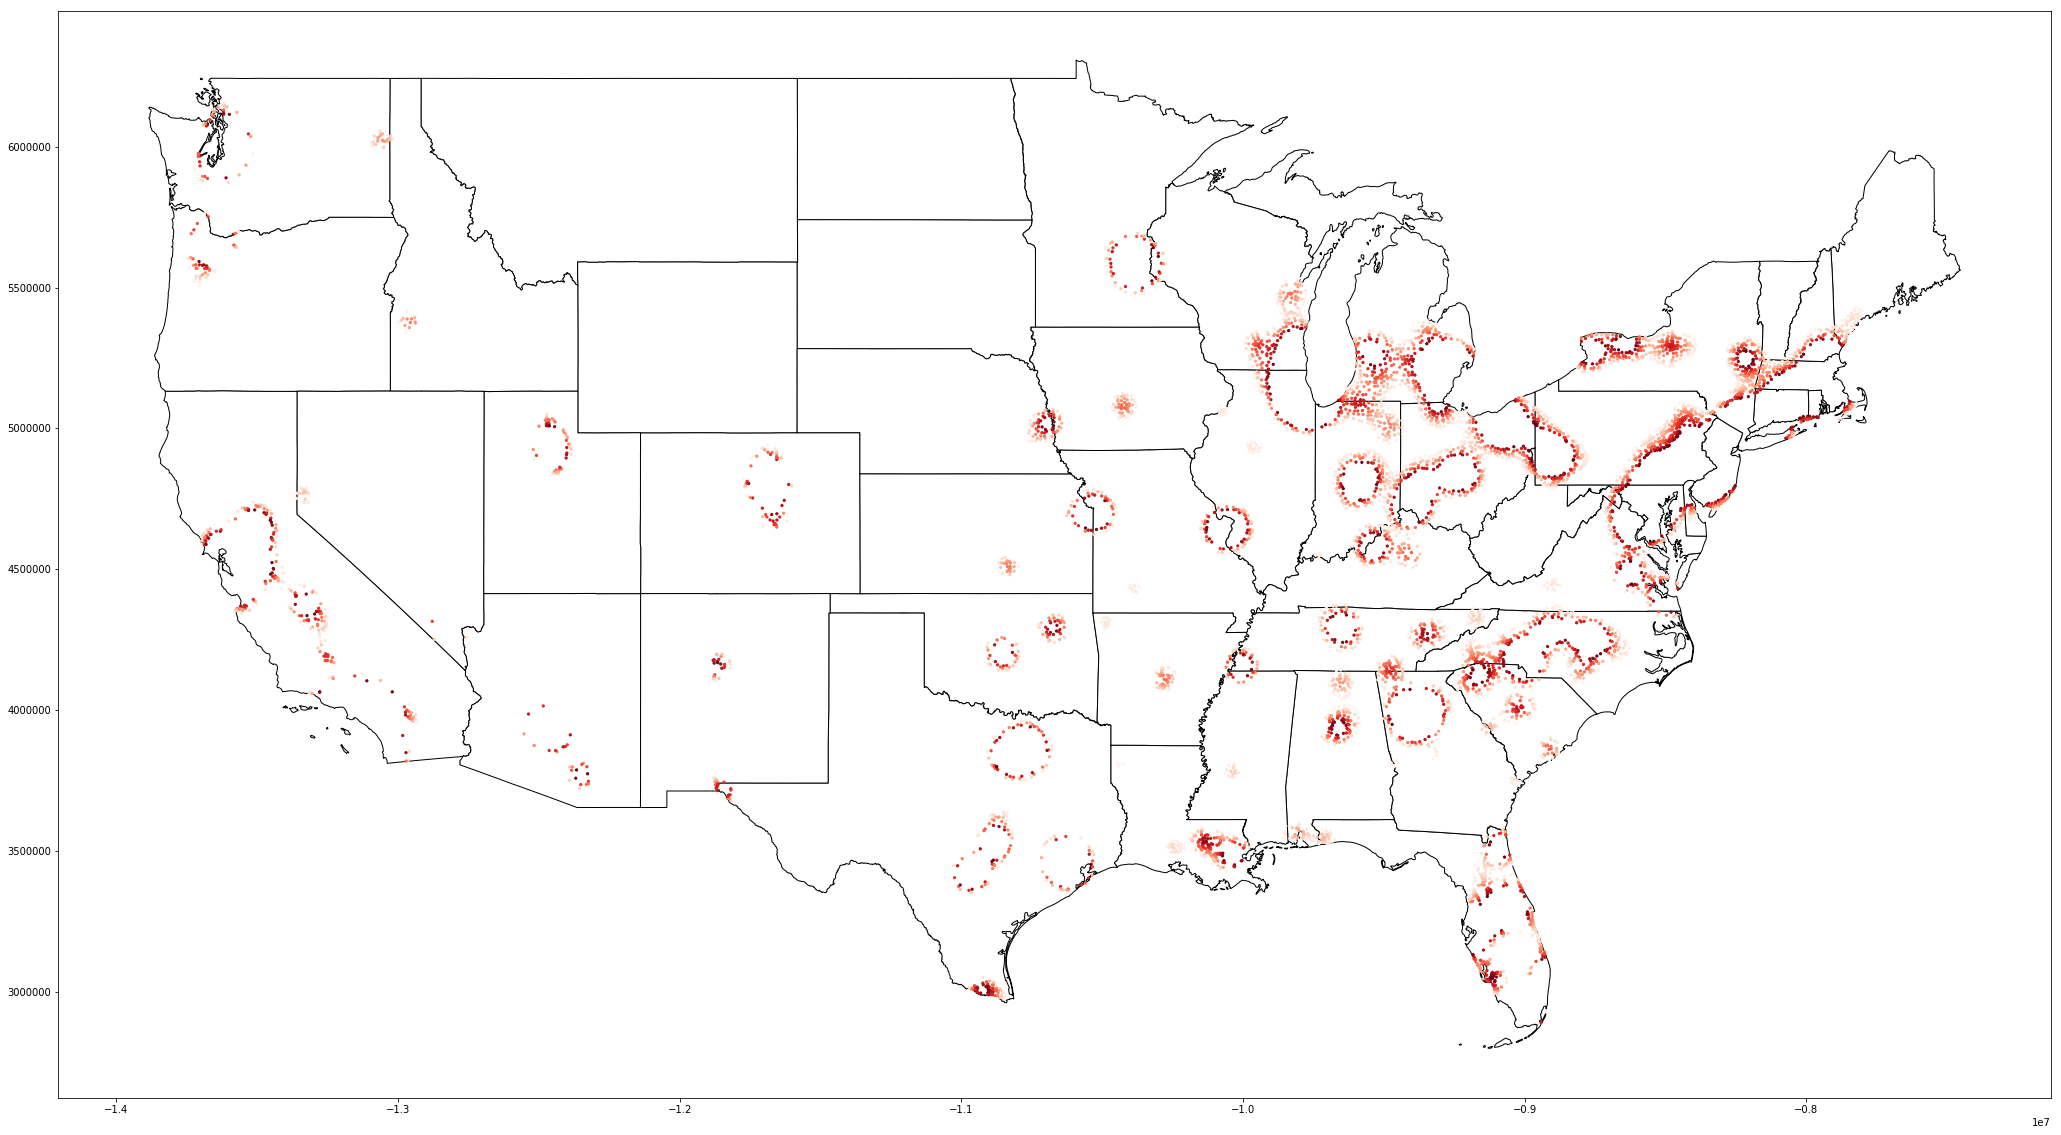

In [109]:
plot_usa(gdf[(gdf.density>0.1)&(gdf.density<0.2)])

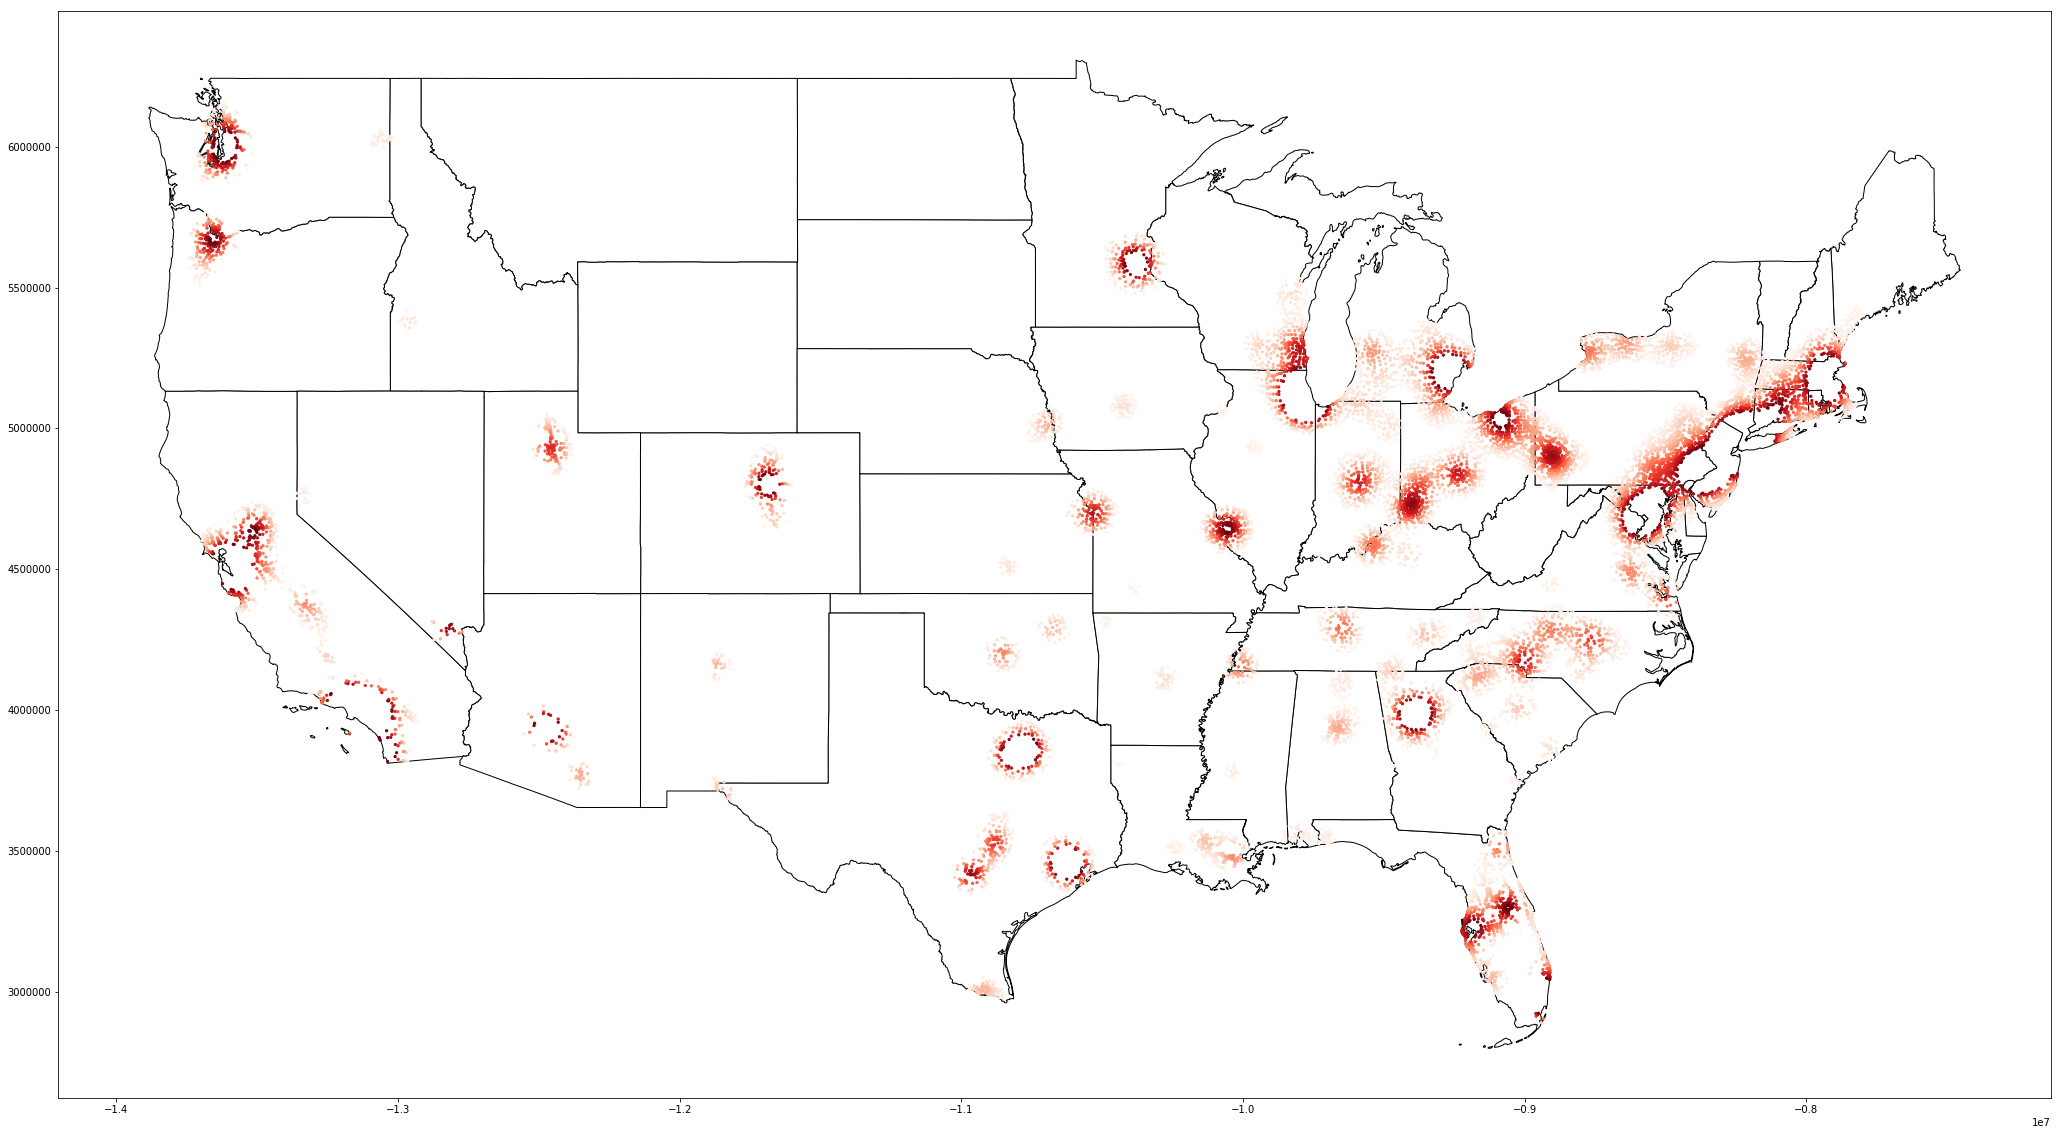

In [111]:
plot_usa(gdf[(gdf.density>0.1)&(gdf.density<0.5)])

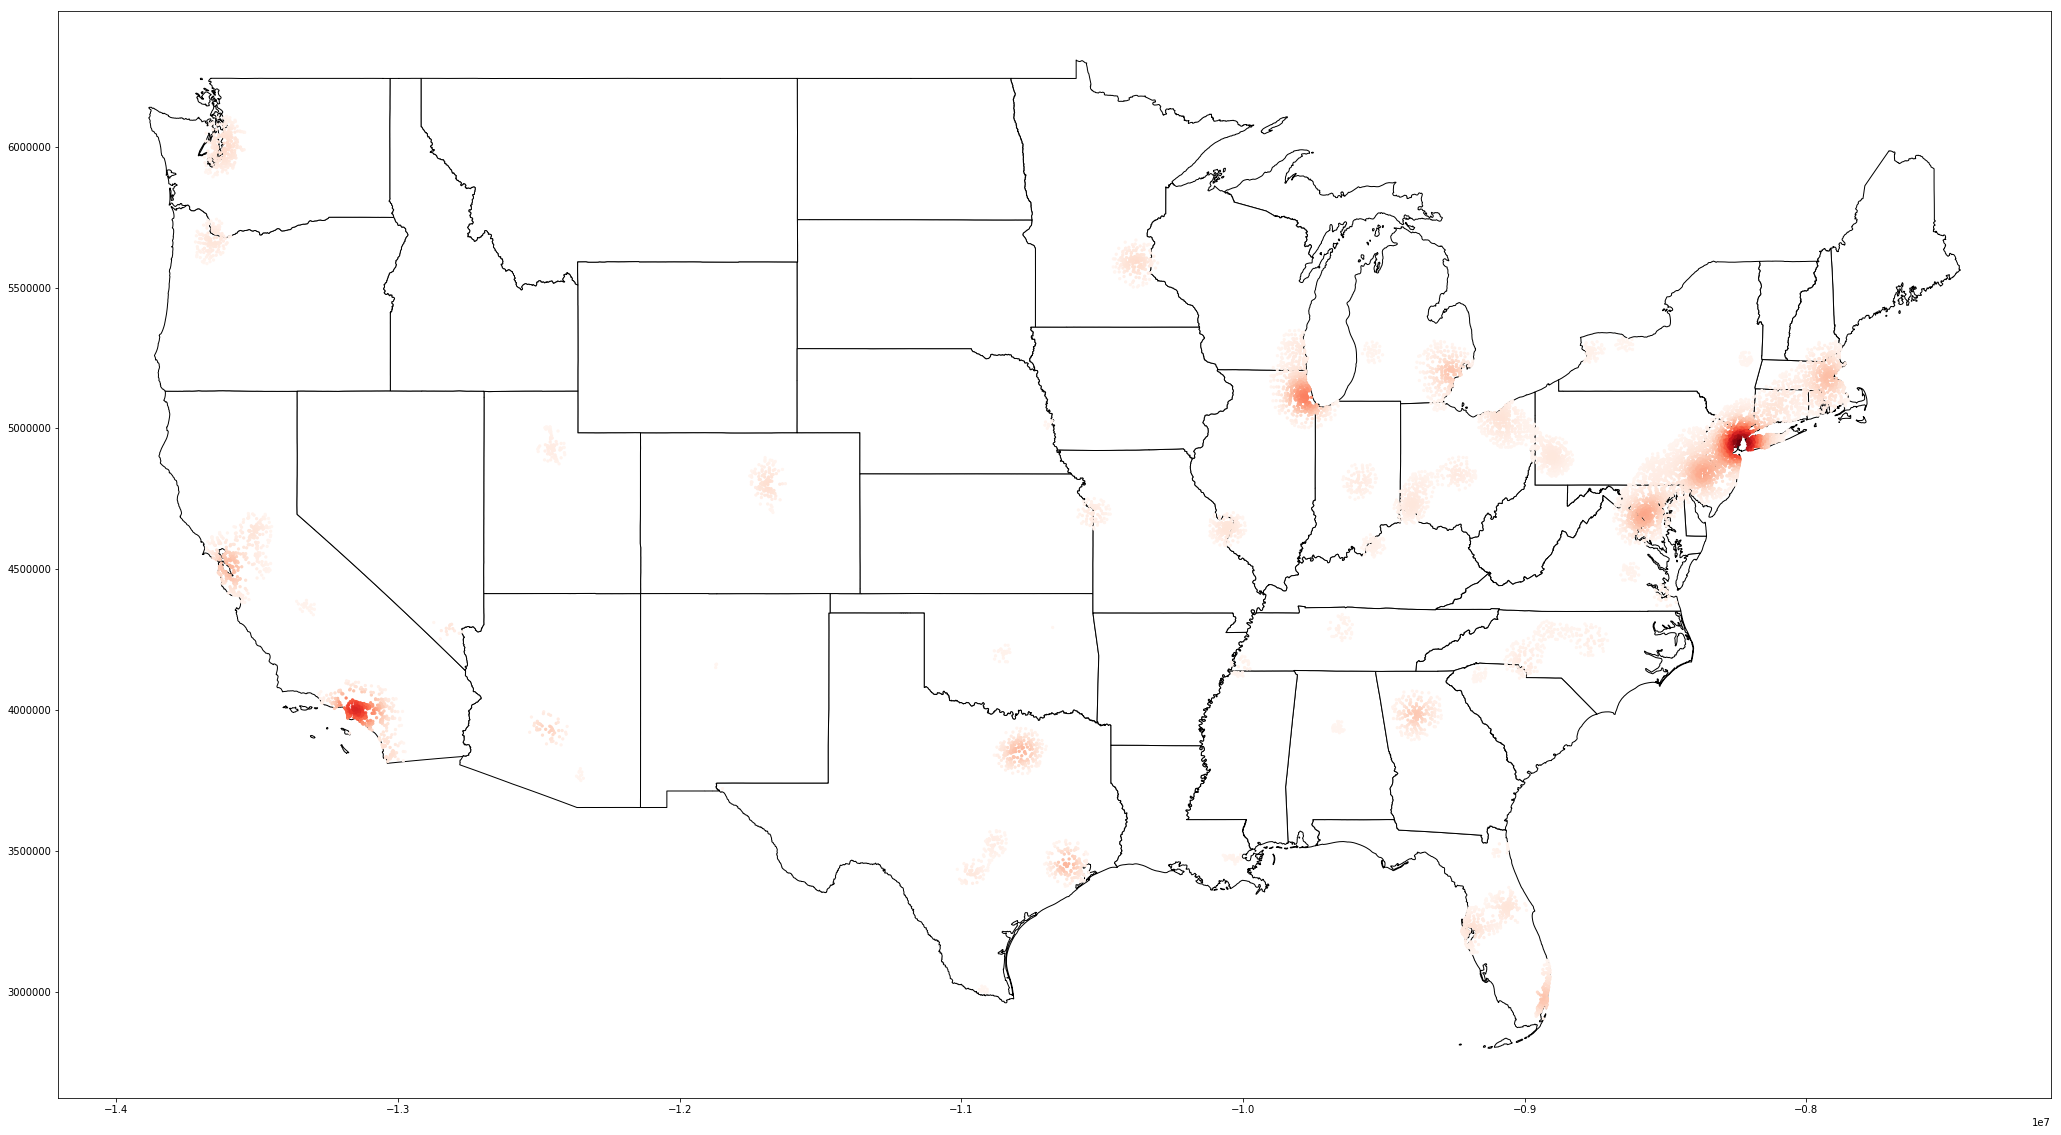

In [110]:
plot_usa(gdf[(gdf.density>0.2)])

In [234]:
gdf[gdf.density<0.1]['count'].sum()

55706479

In [235]:
gdf[(gdf.density>0.1)&(gdf.density<0.2)]['count'].sum()

47746722

In [236]:
gdf[gdf.density>0.2]['count'].sum()

447084804